## Importing initial modules

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Importing data

### Initializing dataframe

In [120]:
df = pd.read_csv('../../datasets/data.csv')
df

,filename,r_mean,g_mean,b_mean,r_std,g_std,b_std,h_mean,v_mean,h_std,v_std,quality
0,imagens/selecionadas/boa_qualidade/3391453209.jpg,132.609966,121.227249,124.231548,77.783824,69.308145,67.421205,13.189166,13.277505,20.334358,21.528245,1
1,imagens/selecionadas/boa_qualidade/3274691778.jpg,66.165817,44.555141,16.569908,69.099801,57.499889,38.438030,5.298978,7.668856,10.649066,16.816179,1
2,imagens/selecionadas/boa_qualidade/3363342011.jpg,77.994858,70.928452,81.287174,95.512351,83.056987,65.150531,4.711894,7.193683,8.418819,13.501021,1
3,imagens/selecionadas/boa_qualidade/3359563671.jpg,75.615658,79.028858,88.636810,38.806435,37.705454,40.135014,3.963080,5.991780,9.907831,13.684910,1
4,imagens/selecionadas/boa_qualidade/3307667255.jpg,112.128551,98.476761,86.907909,67.015909,65.093914,64.762853,8.664269,14.697718,14.127406,23.532887,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2095,imagens/selecionadas/escuras_ruins/2015_03985.jpg,25.093895,24.500557,22.681580,24.635103,23.453142,22.314595,1.650287,1.694096,5.943454,8.405698,0
2096,imagens/selecionadas/escuras_ruins/2015_05839.jpg,16.278244,16.098171,16.927536,26.044997,25.645297,23.383744,0.821251,0.943275,3.102364,3.638713,0
2097,imagens/selecionadas/escuras_ruins/2015_00176.jpg,40.049698,12.688789,3.469101,37.774832,21.465189,8.702481,3.820762,3.532297,7.436229,7.322762,0
2098,imagens/selecionadas/escuras_ruins/2015_03045.png,29.009560,26.468601,24.881416,42.588287,41.339594,40.756837,1.746537,3.285583,5.360037,10.139739,0


### Extracting values

In [121]:
data = (df.values)[:, 1:]

### Splitting into attributes and targets

In [122]:
attributes = data[:, :-1]
targets = data[:, -1]

## Training model

### Modifying sklearn Logistic Regression module to support polynomial features

In [123]:
from numpy import ndarray
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

class PolynomialLogisticRegression(LogisticRegression):
    def __init__(self, penalty = "l2", *, dual: bool = False, tol = 0.0001, C = 1, fit_intercept: bool = True, intercept_scaling = 1, class_weight = None, random_state = None, solver = "lbfgs", max_iter = 100, multi_class = "auto", verbose = 0, warm_start: bool = False, n_jobs = None, l1_ratio = None, degree = 1) -> None:
        super().__init__(penalty, dual=dual, tol=tol, C=C, fit_intercept=fit_intercept, intercept_scaling=intercept_scaling, class_weight=class_weight, random_state=random_state, solver=solver, max_iter=max_iter, multi_class=multi_class, verbose=verbose, warm_start=warm_start, n_jobs=n_jobs, l1_ratio=l1_ratio)
        self.degree = degree
    
    
    def fit(self, X, y, sample_weight = None):
        poly = PolynomialFeatures(self.degree)
        X = poly.fit_transform(X)
        return super().fit(X, y, sample_weight)
    
    
    def predict(self, X) -> ndarray:
        poly = PolynomialFeatures(self.degree)
        X = poly.fit_transform(X)
        return super().predict(X)

    def predict_proba(self, X) -> ndarray:
        poly = PolynomialFeatures(self.degree)
        X = poly.fit_transform(X)
        return super().predict_proba(X)

### Setting parameter grid for Grid Search CV

In [124]:
parameters = {
    'penalty' : ['l2'],
    'C' : [0.001, 0.01, 0.1, 1.0],
    'degree' : range(1, 6),
    'random_state' : [0]
}

### Training and collecting scores

In [125]:
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

folder = KFold(n_splits=10, random_state=0, shuffle=True)
scaler = MinMaxScaler()

metrics = np.zeros((10, 6))

models = [
    [-1.0, None, None, None],
    [2.0, None, None, None]
]

for i, (train_index, test_index) in tqdm(enumerate(folder.split(attributes))):
    train_attributes, test_attributes, train_targets, test_targets = (
        attributes[train_index],
        attributes[test_index],
        targets[train_index],
        targets[test_index]
    )
    
    train_targets = train_targets.astype(float)
    test_targets = test_targets.astype(float)
    
    normal_train_attributes = scaler.fit_transform(train_attributes)
    normal_test_attributes = scaler.transform(test_attributes)
    
    model = PolynomialLogisticRegression()
    cv = GridSearchCV(estimator=model, param_grid=parameters, cv=5)
    
    cv.fit(normal_train_attributes, train_targets)
    
    model = cv.best_estimator_
    model.fit(normal_train_attributes, train_targets)
    
    prediction = model.predict(normal_test_attributes)
    prediction_proba = model.predict_proba(normal_test_attributes)
    
    acc = accuracy_score(test_targets, prediction)
    cm = confusion_matrix(test_targets, prediction, normalize='true')
    prec = precision_score(test_targets, prediction)
    rec = recall_score(test_targets, prediction)
    f1 = f1_score(test_targets, prediction)
    
    metrics[i] = np.array([acc, cm[0][0], cm[1][1], prec, rec, f1]).astype(float)

    if acc > models[0][0]:
        models[0][0] = acc
        models[0][1] = roc_curve(test_targets, prediction_proba[:, 1])
        models[0][2] = precision_recall_curve(test_targets, prediction)
        models[0][3] = cm
    elif acc < models[1][0]:
        models[1][0] = acc
        models[1][1] = roc_curve(test_targets, prediction_proba[:, 1])
        models[1][2] = precision_recall_curve(test_targets, prediction)
        models[1][3] = cm

10it [01:34,  9.48s/it]


## Plotting Results

### Plotting metrics through partitions, means and standard deviations

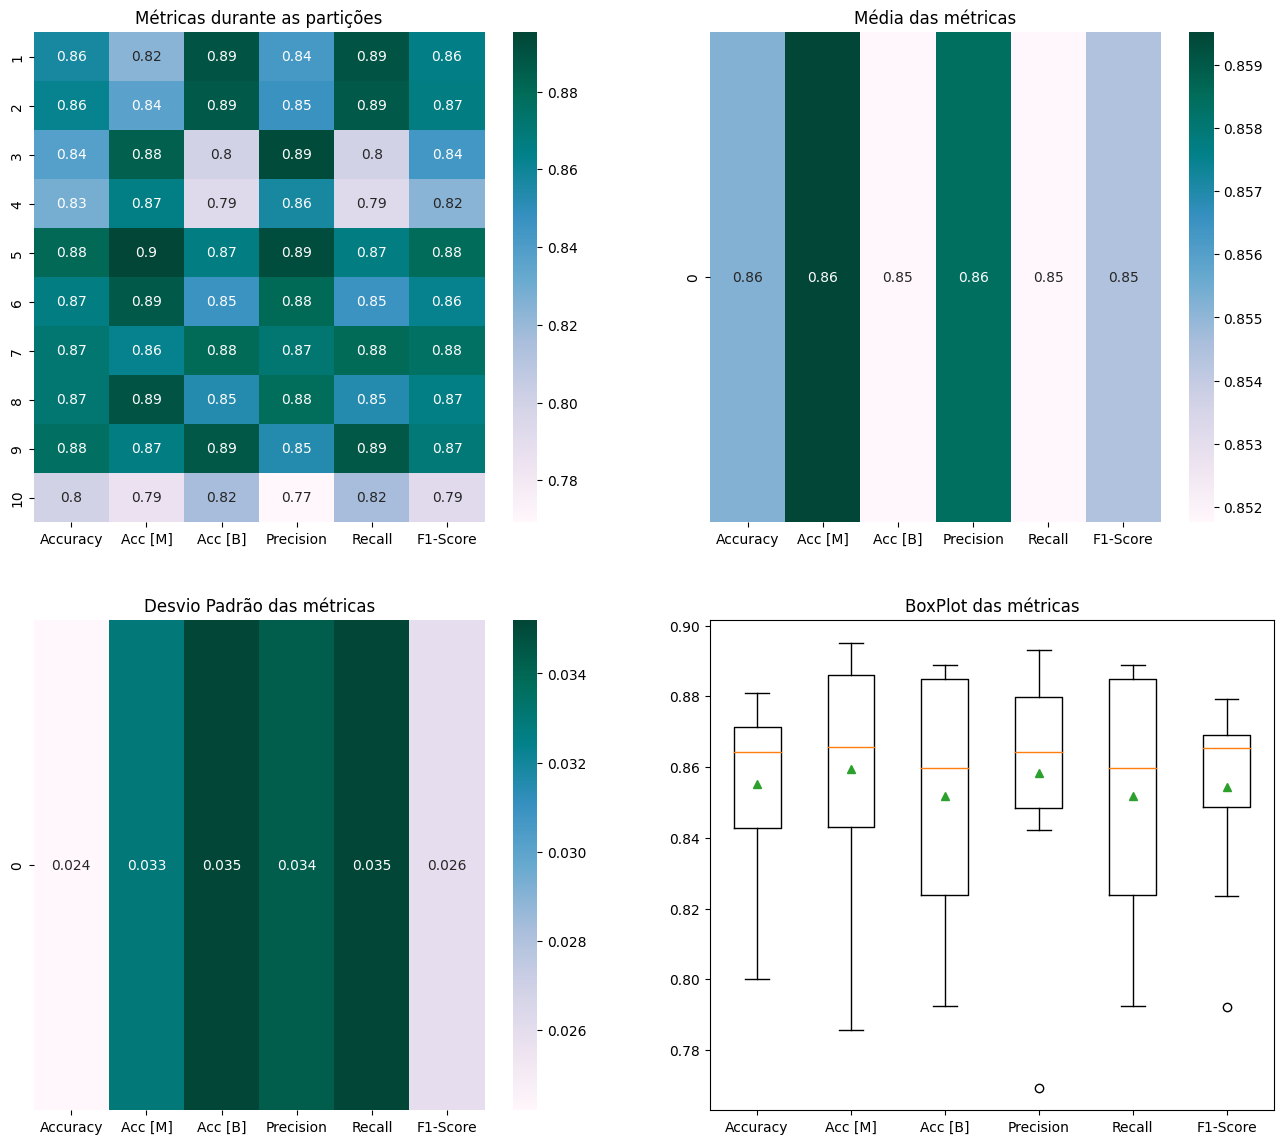

In [126]:
fig, ax = plt.subplots(2, 2, figsize=(16, 14))

xlabels = ['Accuracy', 'Acc [M]', 'Acc [B]', 'Precision', 'Recall', 'F1-Score']

per_fold = sns.heatmap(metrics, annot=True, xticklabels=xlabels, yticklabels=range(1, 11), ax=ax[0][0], cmap='PuBuGn')
means = sns.heatmap(np.mean(metrics, axis=0).reshape(1, -1), annot=True, xticklabels=xlabels, ax=ax[0][1], cmap='PuBuGn')
std = sns.heatmap(np.std(metrics, axis=0).reshape(1, -1), annot=True, xticklabels=xlabels, ax=ax[1][0], cmap='PuBuGn')
ax[1][1].boxplot(metrics, labels=xlabels, showmeans=True)

ax[0][0].set_title('Métricas durante as partições')
ax[0][1].set_title('Média das métricas')
ax[1][0].set_title('Desvio Padrão das métricas')
ax[1][1].set_title('BoxPlot das métricas')

fig.savefig('./charts/metrics.svg')

### Plotting Confusion Matrix, ROC Curve and Precision-Recall curve of both best and worst models

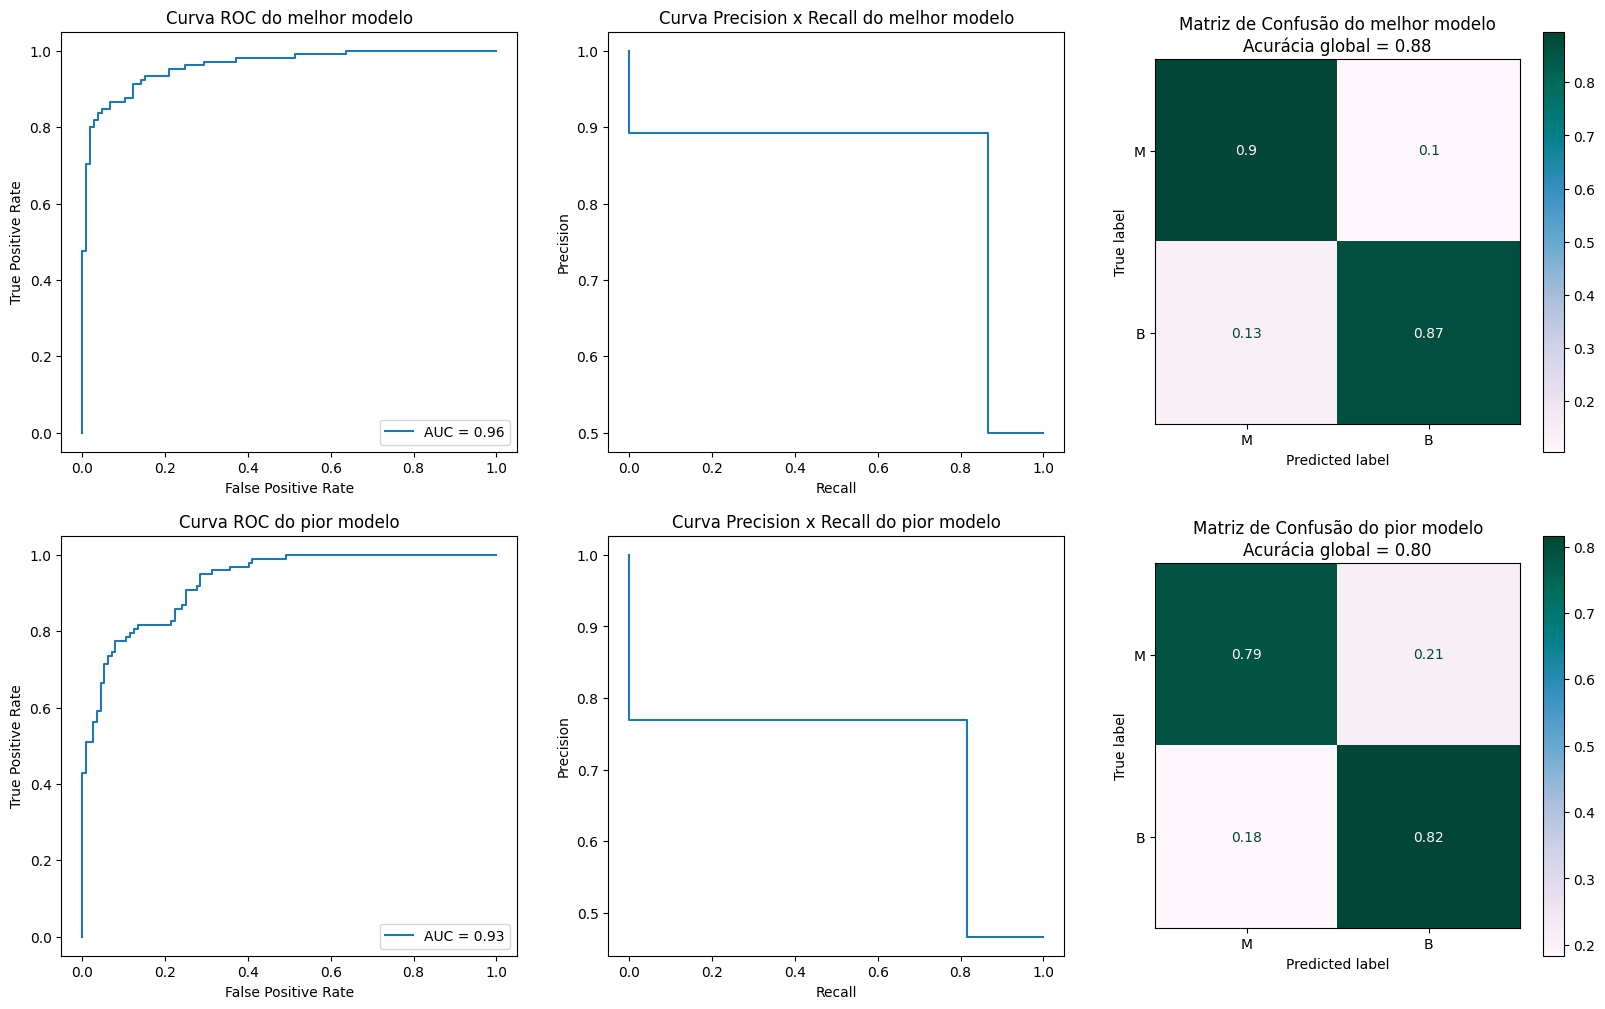

In [127]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay, auc

fig, ax = plt.subplots(2, 3, figsize=(20, 12))

best_roc_display = RocCurveDisplay(fpr=models[0][1][0], tpr=models[0][1][1], roc_auc=auc(models[0][1][0], models[0][1][1]))
best_pr_display = PrecisionRecallDisplay(precision=models[0][2][0], recall=models[0][2][1])
best_cm_display = ConfusionMatrixDisplay(models[0][3], display_labels=['M', 'B'])

worst_roc_display = RocCurveDisplay(fpr=models[1][1][0], tpr=models[1][1][1], roc_auc=auc(models[1][1][0], models[1][1][1]))
worst_pr_display = PrecisionRecallDisplay(precision=models[1][2][0], recall=models[1][2][1])
worst_cm_display = ConfusionMatrixDisplay(models[1][3], display_labels=['M', 'B'])

best_roc_display.plot(ax=ax[0][0])
best_pr_display.plot(ax=ax[0][1])
best_cm_display.plot(ax=ax[0][2], cmap='PuBuGn')

worst_roc_display.plot(ax=ax[1][0])
worst_pr_display.plot(ax=ax[1][1])
worst_cm_display.plot(ax=ax[1][2], cmap='PuBuGn')

ax[0][0].set_title('Curva ROC do melhor modelo')
ax[0][1].set_title('Curva Precision x Recall do melhor modelo')
ax[0][2].set_title(f'Matriz de Confusão do melhor modelo\nAcurácia global = {models[0][0]:.2f}')
ax[1][0].set_title('Curva ROC do pior modelo')
ax[1][1].set_title('Curva Precision x Recall do pior modelo')
ax[1][2].set_title(f'Matriz de Confusão do pior modelo\nAcurácia global = {models[1][0]:.2f}')

fig.savefig('./charts/curves.svg')

## Saving full-trained model

In [128]:
from joblib import dump
final_model = PolynomialLogisticRegression()

final_cv = GridSearchCV(estimator=final_model, param_grid=parameters, cv=5)

normal_attributes = scaler.fit_transform(attributes)

final_cv.fit(normal_attributes, targets.astype(float))

final_model = final_cv.best_estimator_

dump(final_model, './saved_models/poly_log_reg.joblib')

['./saved_models/poly_log_reg.joblib']

In [129]:
final_model

PolynomialLogisticRegression(C=1.0, degree=5, random_state=0)